In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


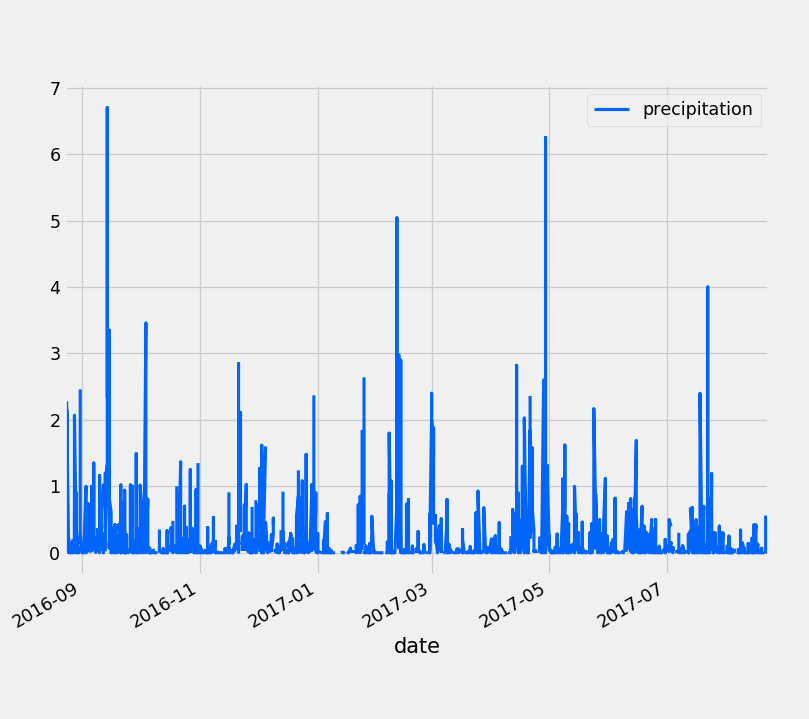

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
# So, the days are 366. That means the first day of the year is included

year_from_last_point = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >=year_from_last_point).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_xx = pd.DataFrame(query,columns=['date', 'precipitation'])

# Reverse datatype from elements to date/time object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
#Then set index to date
precipitation_df.set_index('date', inplace=True)


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
plot = precipitation_df .plot(kind='line', figsize=(9,8),
                      grid=True, fontsize=14, linewidth=2.5, color='xkcd:bright blue')
plt.savefig("images/Percipitation.png")

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station=active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station: {most_active_station}")
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station: USC00519281
Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


<IPython.core.display.Javascript object>


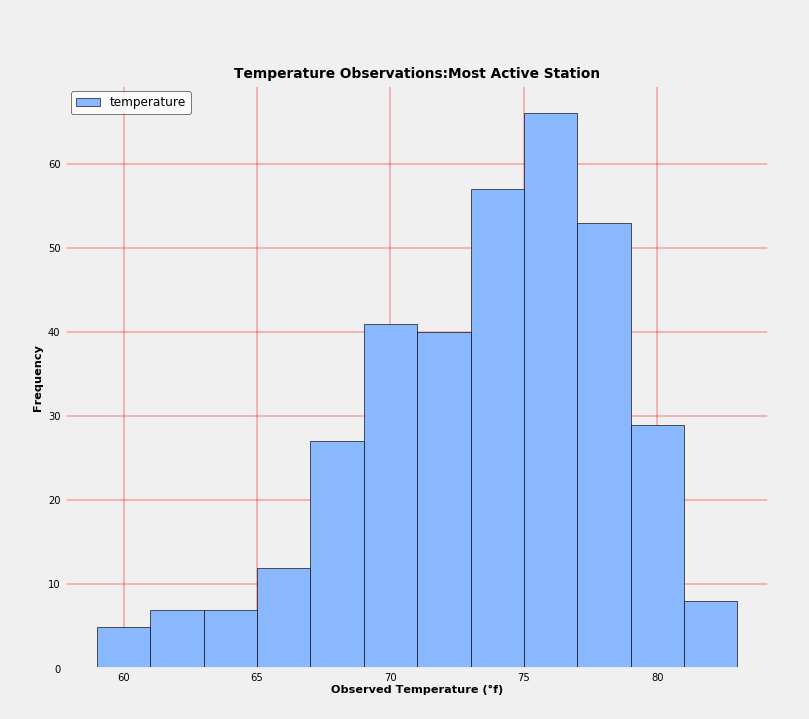

In [15]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_from_last_point).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# This observation is for 12months so we need 12 bins.
hist = temperature_observations.plot.hist(bins=12, figsize=(9,8), edgecolor='k', color='xkcd:carolina blue', fontsize=8)

#Setting histogram properties
hist.figure.set_edgecolor('k')
hist.figure.set_dpi=600
hist.set_title('Temperature Observations:Most Active Station', fontsize=11, weight='bold')
hist.set_ylabel('Frequency', fontsize=9, weight='bold')
hist.grid(color='r', linestyle='-', linewidth=.40)
hist.set_xlabel('Observed Temperature (°f)', fontsize=9, labelpad=1.5, weight='bold')
hist.legend(loc=2, fontsize='x-small', fancybox=True, facecolor='white', edgecolor='k')


plt.savefig("images/Temperature Observations.png")
plt.show()


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


<IPython.core.display.Javascript object>


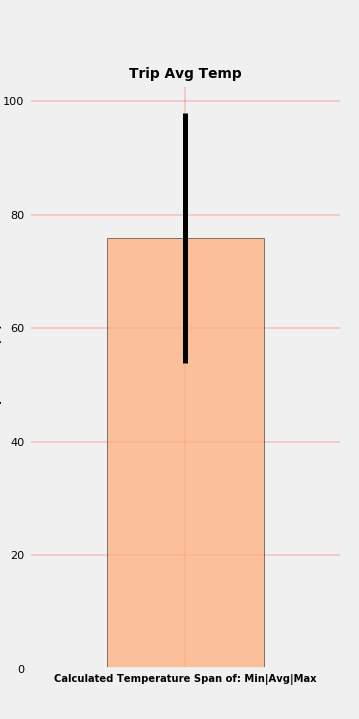

Min Temp     65.0
Name: tmin, dtype: float64, Avg Temp     75.935606
Name: tavg, dtype: float64, Max Temp     87.0
Name: tmax, dtype: float64


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
def calc_temps_x(start, end):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
        Returns:
            Bar chart

    """
    
    #Query data based on function input
    query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date>=start, Measurement.date<=end).all()
    
    # Create a dataframe with the calculated tmin, tavg, and tmax values
    trip_df = pd.DataFrame(query, columns=['tmin', 'tavg', 'tmax'], index=[''])
    TAVG = trip_df['tavg']
    TMIN = trip_df['tmin']
    TMAX = trip_df['tmax']
    

 
    # Use the average temperature for the y value
    # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
    fig, ax = plt.subplots(1,1)
    trip_df.plot.bar(y='tavg', yerr=(TMAX-TMIN), ax=ax, edgecolor='k', color="xkcd:peach", alpha=0.75,
                     figsize=(4,8), fontsize=8, ecolor='xkcd:black')
    
    
    #Set properties for axis lables
    ax.set_ylabel('Temperature (°f)', fontsize=9, labelpad=1.2, weight="bold")
    ax.set_xlabel('Calculated Temperature Span of: Min|Avg|Max',
               fontsize=8, labelpad=1.2, weight="bold")
    
    
    # Use "Trip Avg Temp" as your Title
    ax.set_title('Trip Avg Temp', weight='bold', fontsize=11)
    fig.set_dpi=600
    ax.grid(color='r', linestyle='-', linewidth=.25, which='both')
    ax.yaxis.set_tick_params(labelsize=9)
    ax.xaxis.set_tick_params(rotation='auto', labelsize=9)
    
    plt.gca().legend_.remove()
    plt.show()
    return print('Min Temp %s, Avg Temp %s, Max Temp %s' % (TMIN, TAVG, TMAX)), fig, ax

# for your trip using the previous year's data for those same dates.
x, y, z = calc_temps_x('2017-05-01','2017-06-14')
y.savefig("images/Trip Avg Temp.png")

In [18]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A flexiable list of tuples, based on month and day, containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    flex_start_period = start_date[-5:]
    flex_end_period = end_date[-5:]
    ref_year_start = str(int(start_date[0:4])-2) # subtracting 2 from year to accomodate gap in data, otherwise it would subtract 1.
    ref_year_end = str(int(start_date[0:4])-2) # subtracting 2 from year to accomodate gap in data, otherwise it would subtract 1.
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation,
           Measurement.date,
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date>=f'{ref_year_start}-{flex_start_period}').filter(Measurement.date<=f'{ref_year_end}-{flex_end_period}').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

pd.DataFrame(precipitation('2019-05-15','2019-06-14'))


,station,name,latitude,longitude,elevation,date,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2017-05-15,0.60
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2017-05-15,0.09
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2017-05-15,0.08
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2017-05-15,0.06
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2017-05-15,0.05
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2017-05-15,NaN
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2017-06-02,NaN


## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2019-05-15'
end_date ='2019-06-14'


flex_start_period = start_date[-5:]
flex_end_period = end_date[-5:]
ref_year_start = str(int(start_date[0:4])-2) # subtracting 2 from year to accomodate gap in data, otherwise it would subtract 1.
ref_year_end = str(int(start_date[0:4])-2) # subtracting 2 from year to accomodate gap in data, otherwise it would subtract 1.


# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >=f'{ref_year_start}-{flex_start_period}').filter(Measurement.date <= f'{ref_year_end}-{flex_end_period}').group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]


# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print(f'Aggregate Daily Normals for {flex_start_period} to {flex_end_period}')
daily_normals

Aggregate Daily Normals for 05-15 to 06-14


[(63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864

In [21]:
trip_normals = pd.DataFrame(daily_normals, index=np.asarray(trip_dates, dtype=np.datetime64), columns=['Min_Temp', 'Avg_Temp', 'Max_Temp'], )
trip_normals.head()

,Min_Temp,Avg_Temp,Max_Temp
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0
2017-05-19,65.0,73.807018,79.0


<IPython.core.display.Javascript object>


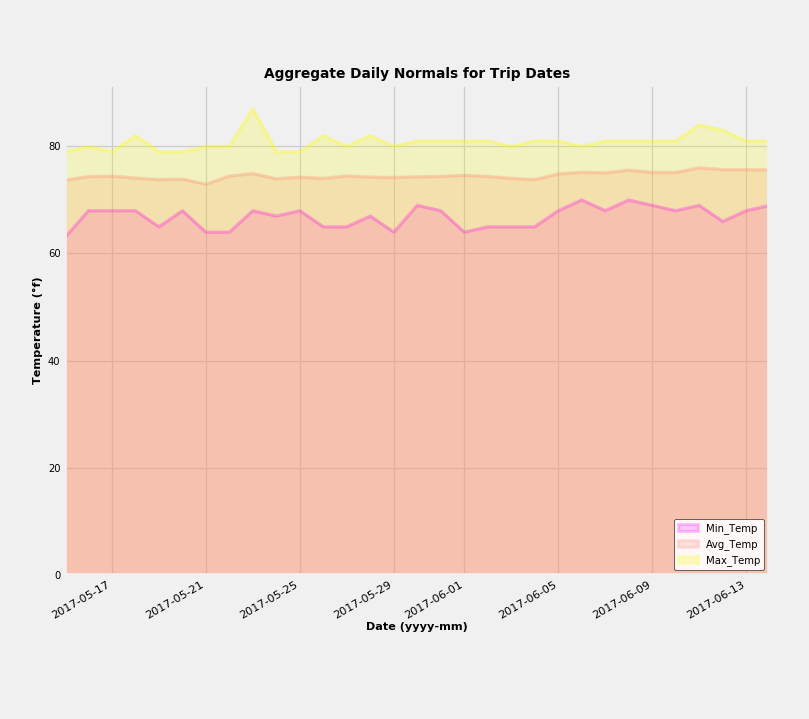

In [22]:
# Plot the daily normals as an area plot with `stacked=False`
area = trip_normals.plot(kind='area', alpha=.20, stacked=False, x_compat=True,
                         fontsize=8, figsize=(9,8), colormap='spring', linewidth=2.5)


#Set area chart properties for axis lables, legend, and title
area.figure.set_edgecolor('k')
area.figure.set_dpi=600
area.set_title('Aggregate Daily Normals for Trip Dates', fontsize=11, weight='bold')
area.set_ylabel('Temperature (°f)', fontsize=9, weight='bold' )
area.grid(color='r', linestyle='-', linewidth=.40, which='minor')
area.set_xlabel('Date (yyyy-mm)', fontsize=9, labelpad=1.5, weight='bold')
area.xaxis.set_tick_params(labelsize=9, which='both')
area.legend(loc=4, fontsize='xx-small', fancybox=True, facecolor='white', edgecolor='k', framealpha=.90 )
area.figure.tight_layout=True

plt.savefig("images/TripDailyNormals.png")
plt.show()